# Merging lyrics into the final dataset

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/ds2.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'data/ds2.csv'

In [ ]:
fds = pd.read_csv("data/final_dataset.csv")

In [ ]:
fds[fds["track_name"]== "S.T.A.Y. (From Interstellar)"]

,source,domain,chart,region,date,position,title,artist,url,scraped_at,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,playlistname


In [ ]:
df.head()

,title,tag,artist,year,views,features,lyrics,id
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6


In [ ]:
fds.columns

Index(['source', 'domain', 'chart', 'region', 'date', 'position', 'title',
       'artist', 'url', 'scraped_at', 'track_name', 'artists', 'album_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'playlistname'],
      dtype='object')

In [ ]:
df = df.drop(labels=["tag","year","views","id","features"], axis=1)

In [ ]:
df.columns

Index(['title', 'artist', 'lyrics'], dtype='object')

In [ ]:
merged = fds.merge(
    df,
    left_on=['track_name', 'artist'],
    right_on=['title', 'artist'],
    how='left'
)


In [ ]:
merged.columns

Index(['source', 'domain', 'chart', 'region', 'date', 'position', 'title_x',
       'artist', 'url', 'scraped_at', 'track_name', 'artists', 'album_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'playlistname', 'title_y', 'lyrics'],
      dtype='object')

In [ ]:
merged = merged.drop("title_y", axis=1)
merged = merged.rename(columns={'title_x': 'title'})

In [ ]:
merged.columns

Index(['source', 'domain', 'chart', 'region', 'date', 'position', 'title',
       'artist', 'url', 'scraped_at', 'track_name', 'artists', 'album_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'playlistname', 'lyrics'],
      dtype='object')

In [ ]:
merged.isna().sum()

source                0
domain                0
chart                 0
region              391
date                 63
position              0
title                 0
artist                0
url                 589
scraped_at            0
track_name            0
artists               0
album_name            0
popularity            0
duration_ms           0
explicit              0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
time_signature        0
track_genre           0
playlistname        541
lyrics              301
dtype: int64

Half of the lyrics are still missing

In [ ]:
import lyricsgenius
import time

genius = lyricsgenius.Genius("Dm_OS9PJm_1854rqdgXQX2BbTRjTb6pQ0kVScZUChIn8eoUvtzKKgjQPC88DuomX")
genius.verbose = False
genius.remove_section_headers = True

def get_lyrics(track_name, artist_name):
    try:
        time.sleep(1)  # avoid rate limit
        song = genius.search_song(track_name, artist_name)
        if song:
            return song.lyrics
        return None
    except Exception as e:
        print(f"--- Error fetching lyrics for {track_name}: {e}")
        return None


In [ ]:
# apply only to missing lyrics
import re

missing_mask = merged['lyrics'].isna()

merged.loc[missing_mask, 'lyrics'] = merged.loc[missing_mask].apply(
    lambda row: get_lyrics(
        re.sub(r"\s*\(.*?\)", "", row['title']).strip('"').strip(),    # clean title
        row['artists'].split(';')[0].strip()                          # first artist
    ),
    axis=1
)


In [ ]:
merged['lyrics'].isna().sum()

np.int64(3)

Still 3 lyrics missing

In [ ]:
merged[merged['lyrics'].isna()]

,source,domain,chart,region,date,position,title,artist,url,scraped_at,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,playlistname,lyrics
326,billboard,billboard.com,hot-100,NaN,2022-01-01,37,Linus And Lucy (Peanuts Theme),Vince Guaraldi Trio,NaN,2025-11-22T15:10:20.303946+00:00,...,0.0380,0.78400,0.927,0.167,0.695,81.774,4,jazz,DW Emotion Exercise - Joy,None
511,top25_research_paper,research_paper,top25_cities,global,2022-01-19,-1,海のリビング,鈴木鈴木,NaN,2025-11-28T03:10:11.431570,...,0.0374,0.09050,0.000,0.242,0.762,97.998,4,j-pop,NaN,None
551,top25_research_paper,research_paper,top25_cities,global,2022-01-19,-1,うっせぇわ,Ado,NaN,2025-11-28T03:10:11.431570,...,0.0815,0.00485,0.000,0.060,0.577,178.069,4,j-pop,NaN,None


In [ ]:
merged.loc[merged["track_name"] == "うっせぇわ", "lyrics"] = get_lyrics("うっせぇわ", "")

2 songs remaining: 1 is instrumental, the other's lyrics are not found by either of the methods, but it's findable on the web

In [ ]:
merged.loc[merged["track_name"] == "海のリビング", "lyrics"] = "太陽が 咲いた\nうざったいくらい部屋ん中\n照らしてくれるじゃんか夏\n男、女 の性が\n暑さに反応 heartbeat\n\nグループLINEに送信 からの一瞬で返信\n目覚めのミルクティー いつもより遥か美味\nお気にのAir Force鏡でチェックして\nあいつの車置き場にダッシュして\n「お待たせ、いやお待たせし過ぎたね」\n“今日を皆んなで最高にする”このポテンシャル\n\n四人乗りの車で走らす\n湾岸線でこの曲流して\nホワイトムスクと 潮風が\n今日の思い出にスパイスを\n\n四人乗りの車で走らす\nそろそろ見えてくる場所は\nパッパッとお悩み 追っ払って\n笑顔を増やす海のリビング yeah\n\n「喉渇いたあ」「一旦コンビニよろ！」\nきんきんに冷えたコーラ\nファミチキ食べて気分豪華\n車のナンバー隠してはいチーズ\n\nうちらがファッション先取り 仲良しこよし\nエンジンかけてBluetooth 「え？え？」\nボリューム上げようか\n\n四人乗りの車で走らす\n湾岸線でこの曲流して\nホワイトムスクと潮風が\n今日の思い出にスパイスを\n\nお金も ないけど\n笑えりゃ無問題\nでもずっとは無いね\nこの気持ち無くさぬように yeah\n\n四人乗りの車で走らす\n海岸沿いでこの曲流して\nホワイトムスクと潮風が\n今日の思い出にスパイスを\n\n四人乗りの車で走らす\nそろそろ見えてくる場所は\n何年経っても 変わらずに\n笑顔を増やす海のリビング yeah"

In [ ]:
merged[merged['lyrics'].isna()]

,source,domain,chart,region,date,position,title,artist,url,scraped_at,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,playlistname,lyrics
326,billboard,billboard.com,hot-100,NaN,2022-01-01,37,Linus And Lucy (Peanuts Theme),Vince Guaraldi Trio,NaN,2025-11-22T15:10:20.303946+00:00,...,0.038,0.784,0.927,0.167,0.695,81.774,4,jazz,DW Emotion Exercise - Joy,None


# Adding a happiness score from lyrics using a prebuilt model

In [ ]:
import re

def clean_lyrics(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'\[.*?\]', '', text)
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [ ]:
d_lyrics = merged.copy()
d_lyrics['lyrics_clean'] = d_lyrics['lyrics'].apply(clean_lyrics)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()  


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
def get_happiness_chunks(text, max_tokens=512):
    words = text.split()
    chunk_size = 200  # ~200 words per chunk; will truncate inside tokenizer
    
    scores = []
    for i in range(0, len(words), chunk_size):
        chunk_text = " ".join(words[i:i+chunk_size])
        
        # Tokenize chunk with truncation
        inputs = tokenizer(
            chunk_text,
            truncation=True,
            padding=True,
            max_length=max_tokens,
            return_tensors="pt"
        )
        
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1).squeeze()
            # Convert logits to stars: 0 -> 1 star, 4 -> 5 stars
            star_score = sum((i+1)*probs[i].item() for i in range(len(probs)))
            # Normalize to 0-1
            happiness = (star_score - 1)/4
            scores.append(happiness)
    
    return np.mean(scores)


In [ ]:
merged['happiness_from_lyrics'] = d_lyrics['lyrics_clean'].apply(get_happiness_chunks)

C:\Users\tomfo\AppData\Roaming\Python\Python313\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\tomfo\AppData\Roaming\Python\Python313\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
merged.head()

,source,domain,chart,region,date,position,title,artist,url,scraped_at,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,playlistname,lyrics,happiness_from_lyrics
0,billboard,billboard.com,hot-100,NaN,2023-01-07,39,Under The Influence,Chris Brown,NaN,2025-11-22T15:08:01.843069+00:00,...,0.0635,0.000001,0.1050,0.310,116.992,4,dance,NaN,"Kido, Kido\nK-K-Kido on the beat, better run i...",0.395045
1,billboard,billboard.com,hot-100,NaN,2022-07-02,45,Efecto,Bad Bunny,NaN,2025-11-22T15:11:28.361775+00:00,...,0.1410,0.000017,0.0639,0.234,98.047,4,latin,NaN,Yeah-yeah-yeah-yeah-yeah-yeah\nEh-eh-eh-eh\n\n...,0.317055
2,billboard,billboard.com,hot-100,NaN,2022-07-02,78,I Ain't Worried,OneRepublic,NaN,2025-11-22T15:11:28.361775+00:00,...,0.0826,0.000745,0.0546,0.825,139.994,4,piano,NaN,I don't know what you've been told\nBut time i...,0.567530
3,billboard,billboard.com,hot-100,NaN,2023-01-07,31,As It Was,Harry Styles,NaN,2025-11-22T15:08:01.843069+00:00,...,0.3420,0.001010,0.3110,0.662,173.930,4,pop,NaN,"[Intro]\nCome on, Harry, we wanna say goodnigh...",0.378523
4,billboard,billboard.com,hot-100,NaN,2022-07-02,8,Glimpse Of Us,Joji,NaN,2025-11-22T15:11:28.361775+00:00,...,0.8910,0.000005,0.1410,0.268,169.914,3,pop,NaN,She'd take the world off my shoulders\nIf it w...,0.521973


In [ ]:
saddest_song = merged.loc[merged['happiness_from_lyrics'].idxmin()]
print(saddest_song)

source                                                top25_research_paper
domain                                                      research_paper
chart                                                         top25_cities
region                                                              global
date                                                            2022-01-19
position                                                                -1
title                                                    Happier Than Ever
artist                                                                ASTN
url                                                                    NaN
scraped_at                                      2025-11-28T03:10:11.431570
track_name                                               Happier Than Ever
artists                                                               ASTN
album_name                                               Happier Than Ever
popularity               

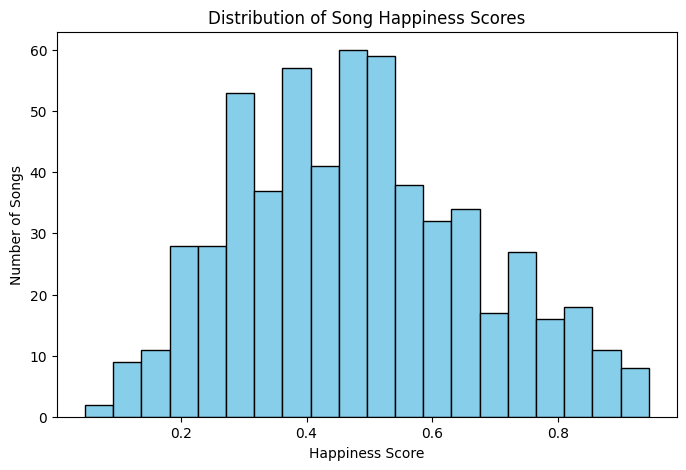

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(merged['happiness_from_lyrics'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Song Happiness Scores')
plt.xlabel('Happiness Score')
plt.ylabel('Number of Songs')
plt.show()

In [ ]:
merged.to_csv("data/dataset_lyrics.csv", index=False)